<a href="https://colab.research.google.com/github/Jbloca/Proyectos/blob/main/IA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Detección de Objetos Custom con YOLO NAS**

## 1. Requerimientos (es necesario utilizar el acelerador de hardware GPU)


In [ ]:

%%capture
!pip install -q super-gradients==3.1.1
!pip install -q roboflow
!pip install -q supervision

⚠️ Una vez instalados los requerimientos, al trabajar en Colab, hay que hacer reset del runtime (este bug 🐞 debería desaparecer próximamente)

```
# Tiene formato de código
```



## 2. Dataset
Se utilizará un dataset de Roboflow, porque el formato es compatible.
---




In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="EHbEWhOmXtzTndb0yzQ5")
project = rf.workspace("shaafz").project("isl-yphyg")
dataset = project.version(2).download("yolov5")


loading Roboflow workspace...
loading Roboflow project...

## 3. Definición de clase `class Config`




In [ ]:
from typing import List, Dict
class config:
    # Project paths
    DATA_DIR: str = "ISL-2"
    CHECKPOINT_DIR: str = "/checkpoints"
    EXPERIMENT_NAME: str = "ISL"

    # Datasets
    TRAIN_IMAGES_DIR: str = "train/images"
    TRAIN_LABELS_DIR: str = "train/labels"
    VAL_IMAGES_DIR: str = "valid/images"
    VAL_LABELS_DIR: str = "valid/labels"
    TEST_IMAGES_DIR: str = "test/images"
    TEST_LABELS_DIR: str = "test/labels"

    # Classes
    CLASSES: List[str] = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
    NUM_CLASSES: int = len(CLASSES)

    # Model
    DATALOADER_PARAMS: Dict = {
        'batch_size':16,
        'num_workers':1
    }
    MODEL_NAME: str = 'yolo_nas_l'
    PRETRAINED_WEIGHTS: str = 'coco'

## 4. Inicialización de Dataloaders

In [ ]:
from super_gradients.training import models
from super_gradients.training import Trainer
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_val
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback


[2023-06-29 20:26:32] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


Setuptools is replacing distutils.
[2023-06-29 20:26:37] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-06-29 20:26:37] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-06-29 20:26:37] WARNING - export.py - Failed to import pytorch_quantization
[2023-06-29 20:26:37] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

Caching annotations: 100%|██████████| 213/213 [00:00<00:00, 5346.32it/s]


### 4.1 Visualización





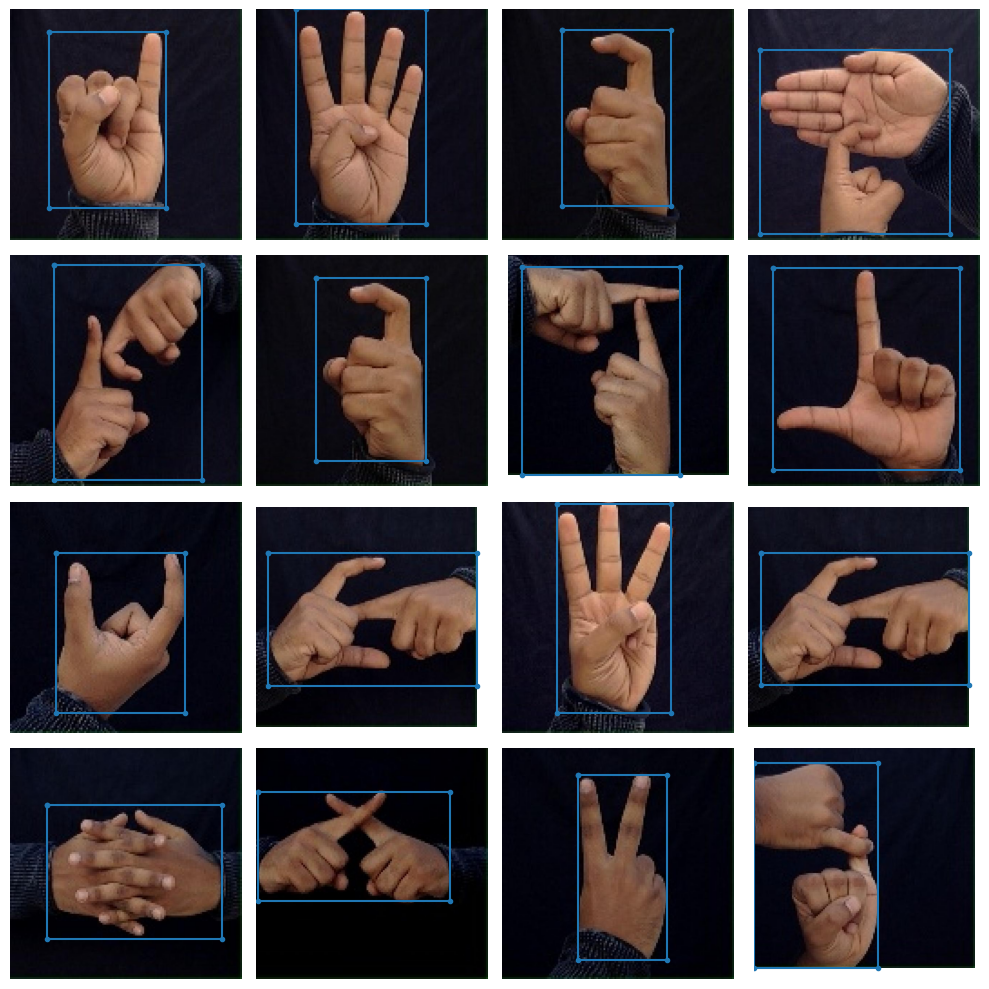

In [ ]:

val_data.dataset.plot()

## 5. Hiperparámetros de entrenamiento

In [ ]:

train_params = {
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 1,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 5,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.8
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}


## 6. Entrenamiento 🚀

### 6.1 Descarga el modelo



In [ ]:
model = models.get(config.MODEL_NAME, num_classes=config.NUM_CLASSES, pretrained_weights=config.PRETRAINED_WEIGHTS)

[2023-06-29 20:27:13] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth


  0%|          | 0.00/256M [00:00<?, ?B/s]

### 6.2 Inicializa el `trainier`



In [ ]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

### 6.3 Entrenar! 🚀🚀🚀🚀🚀

In [ ]:
trainer.train(model=model, training_params=train_params, train_loader=train_data, valid_loader=val_data)

[2023-06-29 20:27:37] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-06-29 20:27:42] INFO - utils.py - NumExpr defaulting to 2 threads.


The console stream is now moved to /checkpoints/ISL/console_Jun29_20_27_42.txt


[2023-06-29 20:27:48] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 2244       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         140        (len(train_loader))
    - Gradient updates per epoch:   140        (len(train_loader) / batch_accumulate)

[2023-06-29 20:27:48] INFO - sg_trainer.py - Started training for 5 epochs (0/4)

Validation epoch 0: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


SUMMARY OF EPOCH 0
├── Training
│   ├── Ppyoloeloss/loss = 3.6906
│   ├── Ppyoloeloss/loss_cls = 2.5202
│   ├── Ppyoloeloss/loss_dfl = 1.3999
│   └── Ppyoloeloss/loss_iou = 0.1882
└── Validation
    ├── F1@0.50 = 0.0
    ├── Map@0.50 = 0.0
    ├── Ppyoloeloss/loss = 3.7645
    ├── Ppyoloeloss/loss_cls = 2.84
    ├── Ppyoloeloss/loss_dfl = 1.2265
    ├── Ppyoloeloss/loss_iou = 0.1245
    ├── Precision@0.50 = 0.0
    └── Recall@0.50 = 0.0



[2023-06-29 20:31:31] INFO - base_sg_logger.py - Checkpoint saved in /checkpoints/ISL/ckpt_best.pth
[2023-06-29 20:31:31] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.0
Validation epoch 1: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


SUMMARY OF EPOCH 1
├── Training
│   ├── Ppyoloeloss/loss = 2.967
│   │   ├── Best until now = 3.6906 (↘ -0.7236)
│   │   └── Epoch N-1      = 3.6906 (↘ -0.7236)
│   ├── Ppyoloeloss/loss_cls = 1.9128
│   │   ├── Best until now = 2.5202 (↘ -0.6074)
│   │   └── Epoch N-1      = 2.5202 (↘ -0.6074)
│   ├── Ppyoloeloss/loss_dfl = 1.3099
│   │   ├── Best until now = 1.3999 (↘ -0.09)
│   │   └── Epoch N-1      = 1.3999 (↘ -0.09)
│   └── Ppyoloeloss/loss_iou = 0.1597
│       ├── Best until now = 0.1882 (↘ -0.0285)
│       └── Epoch N-1      = 0.1882 (↘ -0.0285)
└── Validation
    ├── F1@0.50 = 0.0135
    │   ├── Best until now = 0.0    (↗ 0.0135)
    │   └── Epoch N-1      = 0.0    (↗ 0.0135)
    ├── Map@0.50 = 0.15
    │   ├── Best until now = 0.0    (↗ 0.15)
    │   └── Epoch N-1      = 0.0    (↗ 0.15)
    ├── Ppyoloeloss/loss = 2.5124
    │   ├── Best until now = 3.7645 (↘ -1.2522)
    │   └── Epoch N-1      = 3.7645 (↘ -1.2522)
    ├── Ppyoloeloss/loss_cls = 1.7598
    │   ├── Best until no

[2023-06-29 20:35:18] INFO - base_sg_logger.py - Checkpoint saved in /checkpoints/ISL/ckpt_best.pth
[2023-06-29 20:35:18] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.15000461041927338
Validation epoch 2: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


SUMMARY OF EPOCH 2
├── Training
│   ├── Ppyoloeloss/loss = 2.53
│   │   ├── Best until now = 2.967  (↘ -0.437)
│   │   └── Epoch N-1      = 2.967  (↘ -0.437)
│   ├── Ppyoloeloss/loss_cls = 1.6318
│   │   ├── Best until now = 1.9128 (↘ -0.281)
│   │   └── Epoch N-1      = 1.9128 (↘ -0.281)
│   ├── Ppyoloeloss/loss_dfl = 1.1386
│   │   ├── Best until now = 1.3099 (↘ -0.1713)
│   │   └── Epoch N-1      = 1.3099 (↘ -0.1713)
│   └── Ppyoloeloss/loss_iou = 0.1315
│       ├── Best until now = 0.1597 (↘ -0.0281)
│       └── Epoch N-1      = 0.1597 (↘ -0.0281)
└── Validation
    ├── F1@0.50 = 0.0499
    │   ├── Best until now = 0.0135 (↗ 0.0365)
    │   └── Epoch N-1      = 0.0135 (↗ 0.0365)
    ├── Map@0.50 = 0.2735
    │   ├── Best until now = 0.15   (↗ 0.1235)
    │   └── Epoch N-1      = 0.15   (↗ 0.1235)
    ├── Ppyoloeloss/loss = 2.0173
    │   ├── Best until now = 2.5124 (↘ -0.495)
    │   └── Epoch N-1      = 2.5124 (↘ -0.495)
    ├── Ppyoloeloss/loss_cls = 1.3895
    │   ├── Best until

[2023-06-29 20:39:00] INFO - base_sg_logger.py - Checkpoint saved in /checkpoints/ISL/ckpt_best.pth
[2023-06-29 20:39:00] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.2735423445701599
Validation epoch 3: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


SUMMARY OF EPOCH 3
├── Training
│   ├── Ppyoloeloss/loss = 2.2804
│   │   ├── Best until now = 2.53   (↘ -0.2495)
│   │   └── Epoch N-1      = 2.53   (↘ -0.2495)
│   ├── Ppyoloeloss/loss_cls = 1.4822
│   │   ├── Best until now = 1.6318 (↘ -0.1496)
│   │   └── Epoch N-1      = 1.6318 (↘ -0.1496)
│   ├── Ppyoloeloss/loss_dfl = 1.041
│   │   ├── Best until now = 1.1386 (↘ -0.0976)
│   │   └── Epoch N-1      = 1.1386 (↘ -0.0976)
│   └── Ppyoloeloss/loss_iou = 0.1111
│       ├── Best until now = 0.1315 (↘ -0.0204)
│       └── Epoch N-1      = 0.1315 (↘ -0.0204)
└── Validation
    ├── F1@0.50 = 0.0691
    │   ├── Best until now = 0.0499 (↗ 0.0191)
    │   └── Epoch N-1      = 0.0499 (↗ 0.0191)
    ├── Map@0.50 = 0.4329
    │   ├── Best until now = 0.2735 (↗ 0.1594)
    │   └── Epoch N-1      = 0.2735 (↗ 0.1594)
    ├── Ppyoloeloss/loss = 1.8665
    │   ├── Best until now = 2.0173 (↘ -0.1508)
    │   └── Epoch N-1      = 2.0173 (↘ -0.1508)
    ├── Ppyoloeloss/loss_cls = 1.2632
    │   ├── Bes

[2023-06-29 20:43:06] INFO - base_sg_logger.py - Checkpoint saved in /checkpoints/ISL/ckpt_best.pth
[2023-06-29 20:43:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.4328976571559906
Validation epoch 4: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


SUMMARY OF EPOCH 4
├── Training
│   ├── Ppyoloeloss/loss = 2.0985
│   │   ├── Best until now = 2.2804 (↘ -0.182)
│   │   └── Epoch N-1      = 2.2804 (↘ -0.182)
│   ├── Ppyoloeloss/loss_cls = 1.3601
│   │   ├── Best until now = 1.4822 (↘ -0.1221)
│   │   └── Epoch N-1      = 1.4822 (↘ -0.1221)
│   ├── Ppyoloeloss/loss_dfl = 0.9852
│   │   ├── Best until now = 1.041  (↘ -0.0558)
│   │   └── Epoch N-1      = 1.041  (↘ -0.0558)
│   └── Ppyoloeloss/loss_iou = 0.0983
│       ├── Best until now = 0.1111 (↘ -0.0128)
│       └── Epoch N-1      = 0.1111 (↘ -0.0128)
└── Validation
    ├── F1@0.50 = 0.0852
    │   ├── Best until now = 0.0691 (↗ 0.0161)
    │   └── Epoch N-1      = 0.0691 (↗ 0.0161)
    ├── Map@0.50 = 0.6482
    │   ├── Best until now = 0.4329 (↗ 0.2153)
    │   └── Epoch N-1      = 0.4329 (↗ 0.2153)
    ├── Ppyoloeloss/loss = 1.7232
    │   ├── Best until now = 1.8665 (↘ -0.1433)
    │   └── Epoch N-1      = 1.8665 (↘ -0.1433)
    ├── Ppyoloeloss/loss_cls = 1.1584
    │   ├── Best

[2023-06-29 20:47:18] INFO - base_sg_logger.py - Checkpoint saved in /checkpoints/ISL/ckpt_best.pth
[2023-06-29 20:47:18] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6482036709785461
[2023-06-29 20:47:49] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validation epoch 5: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


SUMMARY OF EPOCH 5
├── Training
│   ├── Ppyoloeloss/loss = 2.0985
│   │   ├── Best until now = 2.2804 (↘ -0.182)
│   │   └── Epoch N-1      = 2.2804 (↘ -0.182)
│   ├── Ppyoloeloss/loss_cls = 1.3601
│   │   ├── Best until now = 1.4822 (↘ -0.1221)
│   │   └── Epoch N-1      = 1.4822 (↘ -0.1221)
│   ├── Ppyoloeloss/loss_dfl = 0.9852
│   │   ├── Best until now = 1.041  (↘ -0.0558)
│   │   └── Epoch N-1      = 1.041  (↘ -0.0558)
│   └── Ppyoloeloss/loss_iou = 0.0983
│       ├── Best until now = 0.1111 (↘ -0.0128)
│       └── Epoch N-1      = 0.1111 (↘ -0.0128)
└── Validation
    ├── F1@0.50 = 0.1268
    │   ├── Best until now = 0.0852 (↗ 0.0416)
    │   └── Epoch N-1      = 0.0852 (↗ 0.0416)
    ├── Map@0.50 = 0.3294
    │   ├── Best until now = 0.6482 (↘ -0.3188)
    │   └── Epoch N-1      = 0.6482 (↘ -0.3188)
    ├── Ppyoloeloss/loss = 2.2874
    │   ├── Best until now = 1.7232 (↗ 0.5642)
    │   └── Epoch N-1      = 1.7232 (↗ 0.5642)
    ├── Ppyoloeloss/loss_cls = 1.7241
    │   ├── Best

## 7. Cargar el mejor modelo

In [ ]:
  import os
  avg_model = models.get(config.MODEL_NAME,
                          num_classes=config.NUM_CLASSES,
                          checkpoint_path=os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, 'average_model.pth'))

[2023-06-29 20:49:09] INFO - checkpoint_utils.py - Successfully loaded model weights from /checkpoints/ISL/average_model.pth EMA checkpoint.


## 8. Evaluación con `test_dataloader`

In [ ]:

trainer.test(model=avg_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=config.NUM_CLASSES,
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, nms_top_k=1000, max_predictions=300,         nms_threshold=0.7)
                                                  ))

Test: 100%|██████████| 6/6 [00:05<00:00,  1.20it/s]

{'PPYoloELoss/loss_cls': 1.1896276,
 'PPYoloELoss/loss_iou': 0.06636592,
 'PPYoloELoss/loss_dfl': 0.80759615,
 'PPYoloELoss/loss': 1.7593406,
 'Precision@0.50': tensor(0.0524),
 'Recall@0.50': tensor(0.9937),
 'mAP@0.50': tensor(0.7030),
 'F1@0.50': tensor(0.0981)}

In [ ]:
import supervision

# Utiliza dir() para obtener los atributos y métodos de supervision
print(dir(supervision))

['BaseDataset', 'BoxAnnotator', 'ClassificationDataset', 'Classifications', 'Color', 'ColorPalette', 'DetectionDataset', 'Detections', 'ImageSink', 'LineZone', 'LineZoneAnnotator', 'MaskAnnotator', 'Point', 'PolygonZone', 'PolygonZoneAnnotator', 'Position', 'Rect', 'VideoInfo', 'VideoSink', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'box_iou_batch', 'classification', 'crop', 'dataset', 'detection', 'draw', 'draw_filled_rectangle', 'draw_polygon', 'draw_text', 'filter_polygons_by_area', 'geometry', 'get_polygon_center', 'get_video_frames_generator', 'list_files_with_extensions', 'mask_to_polygons', 'mask_to_xyxy', 'non_max_suppression', 'plot_image', 'plot_images_grid', 'polygon_to_mask', 'polygon_to_xyxy', 'process_video', 'utils']


In [ ]:
import supervision

# Accede al atributo deseado
attribute_value = supervision.dataset

# Imprime el valor del atributo
print(attribute_value)


<module 'supervision.dataset' from '/usr/local/lib/python3.10/dist-packages/supervision/dataset/__init__.py'>


## 9. Visualización

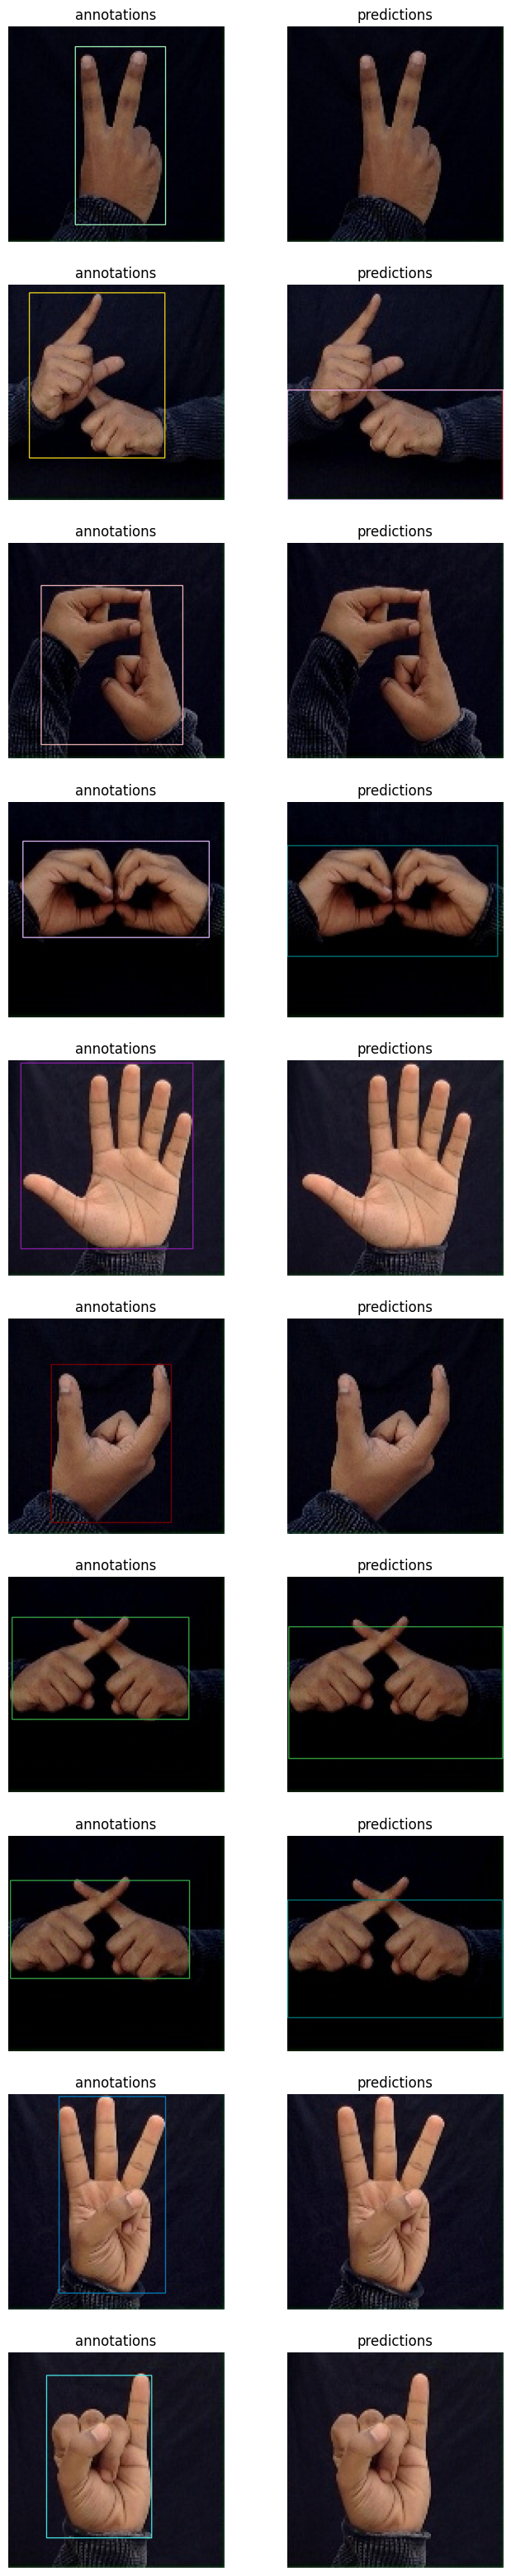

In [ ]:
import random
import supervision as sv
random.seed(10)
ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{config.DATA_DIR}/test/images",
    annotations_directory_path=f"{config.DATA_DIR}/test/labels",
    data_yaml_path=f"{config.DATA_DIR}/data.yaml",
    force_masks=False
)



predictions = {}

CONFIDENCE_THRESHOLD = 0.3

#Inferencia
for image_name, image in ds.images.items():
    result = list(avg_model.predict(image, conf=CONFIDENCE_THRESHOLD))[0]
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int)
    )
    predictions[image_name] = detections



#Plot anotaciones vs predicciones
MAX_IMAGE_COUNT = 10

n = min(MAX_IMAGE_COUNT, len(ds.images))

keys = list(ds.images.keys())
keys = random.sample(keys, n)

box_annotator = sv.BoxAnnotator()

images = []
titles = []

for key in keys:
    frame_with_annotations = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=ds.annotations[key],
        skip_label=True
    )
    images.append(frame_with_annotations)
    titles.append('annotations')
    frame_with_predictions = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=predictions[key],
        skip_label=True
    )
    images.append(frame_with_predictions)
    titles.append('predictions')

%matplotlib inline
sv.plot_images_grid(images=images, titles=titles, grid_size=(n, 2), size=(2 * 4, n * 4))